In [13]:
#!/usr/bin/env python

import numpy as np
import random

from utils.gradcheck import gradcheck_naive
from utils.utils import normalizeRows, softmax


def sigmoid(x):
    """
    Compute the sigmoid function for the input here.
    Arguments:
    x -- A scalar or numpy array.
    Return:
    s -- sigmoid(x)
    """

    ### YOUR CODE HERE
    s = 1 / (1 + np.exp(-1 * x))
    ### END YOUR CODE

    return s

Word2Vec  
모든 word가 center word이자 다른 word의 outside word입니다.  
어떤 word로 쓰이냐에 따라서 현재 역할이 달라지기 때문에 모든 word는 outside vector와 center vector 2개를 모두 갖고 있습니다.  
우리의 목표는 P(O|C)를 최대화하는 것입니다. 최대화하기 위해서 먼저 word o(center word c의 window 안에 있는 outside word), word c(center word)에 대해서 P(O=o|C=c)를 정확히 구해야 합니다.

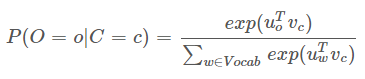

여기서 uo 는 outside word o의 outside vector이고 vc는 center word c의 center vector입니다. 이 파라미터들을 포함하는 행렬로 U, V 2개가 있습니다. 각각 모든 단어들의 outside vector, center vector입니다.

loss는 다음 식으로 주어집니다.

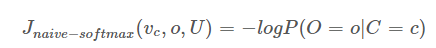

In [14]:
def naiveSoftmaxLossAndGradient(
    centerWordVec,
    outsideWordIdx,
    outsideVectors,
    dataset
):
    """ Naive Softmax loss & gradient function for word2vec models

    Implement the naive softmax loss and gradients between a center word's 
    embedding and an outside word's embedding. This will be the building block
    for our word2vec models.

    Arguments:
    centerWordVec -- numpy ndarray, center word's embedding
                    (v_c in the pdf handout)
    outsideWordIdx -- integer, the index of the outside word
                    (o of u_o in the pdf handout)
    outsideVectors -- outside vectors (rows of matrix) for all words in vocab
                      (U in the pdf handout)
    dataset -- needed for negative sampling, unused here.

    Return:
    loss -- naive softmax loss
    gradCenterVec -- the gradient with respect to the center word vector
                     (dJ / dv_c in the pdf handout)
    gradOutsideVecs -- the gradient with respect to all the outside word vectors
                    (dJ / dU)
    """

    ### YOUR CODE HERE

    ### Please use the provided softmax function (imported earlier in this file)
    ### This numerically stable implementation helps you avoid issues pertaining
    ### to integer overflow. 
    y_hat = softmax(np.dot(outsideVectors, centerWordVec))
    loss = -np.log(y_hat[outsideWordIdx])

    y = np.zeros(y_hat.shape)
    y[outsideWordIdx] = 1
    gradCenterVec = np.dot(y_hat - y, outsideVectors)
    gradOutsideVecs = np.outer(y_hat - y, centerWordVec)


    ### END YOUR CODE

    return loss, gradCenterVec, gradOutsideVecs

K개의 negative sample(w1,⋯,wK) 이 주어졌을 때

In [15]:
def getNegativeSamples(outsideWordIdx, dataset, K):
    """ Samples K indexes which are not the outsideWordIdx """

    negSampleWordIndices = [None] * K
    for k in range(K):
        newidx = dataset.sampleTokenIdx()
        while newidx == outsideWordIdx:
            newidx = dataset.sampleTokenIdx()
        negSampleWordIndices[k] = newidx
    return negSampleWordIndices

negative sampling loss function은 다음과 같습니다.

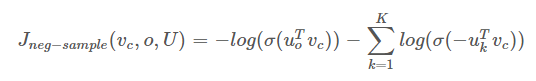

In [16]:
def negSamplingLossAndGradient(
    centerWordVec,
    outsideWordIdx,
    outsideVectors,
    dataset,
    K=10
):
    """ Negative sampling loss function for word2vec models

    Implement the negative sampling loss and gradients for a centerWordVec
    and a outsideWordIdx word vector as a building block for word2vec
    models. K is the number of negative samples to take.

    Note: The same word may be negatively sampled multiple times. For
    example if an outside word is sampled twice, you shall have to
    double count the gradient with respect to this word. Thrice if
    it was sampled three times, and so forth.

    Arguments/Return Specifications: same as naiveSoftmaxLossAndGradient
    """

    # Negative sampling of words is done for you. Do not modify this if you
    # wish to match the autograder and receive points!
    negSampleWordIndices = getNegativeSamples(outsideWordIdx, dataset, K)
    indices = [outsideWordIdx] + negSampleWordIndices

    ### YOUR CODE HERE

    ### Please use your implementation of sigmoid in here.
    posSample = outsideVectors[outsideWordIdx]
    negSample = outsideVectors[negSampleWordIndices]
    posSgm = sigmoid(np.dot(posSample,centerWordVec))
    negSgm = sigmoid(- np.dot(negSample,centerWordVec))
    
    loss = -np.log(posSgm) - np.sum(np.log(negSgm))

    gradCenterVec = -np.dot(posSample, (1 - posSgm)) + np.dot(negSample.T, (1 - negSgm))
    
    gradOutsideVecs = np.zeros(outsideVectors.shape)
    tmpOutsideVecs = np.outer(1 - negSgm, centerWordVec)
    for i, vecs in enumerate(negSampleWordIndices):
        gradOutsideVecs[vecs] += tmpOutsideVecs[i]
    gradOutsideVecs[outsideWordIdx] += - (1 - posSgm) * centerWordVec

    ### END YOUR CODE

    return loss, gradCenterVec, gradOutsideVecs

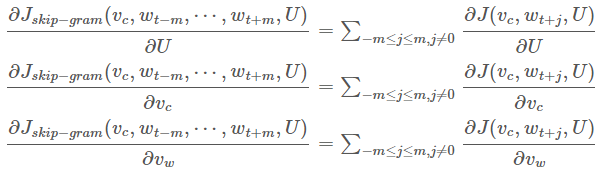

In [17]:
def skipgram(currentCenterWord, windowSize, outsideWords, word2Ind,
             centerWordVectors, outsideVectors, dataset,
             word2vecLossAndGradient=naiveSoftmaxLossAndGradient):
    """ Skip-gram model in word2vec

    Implement the skip-gram model in this function.

    Arguments:
    currentCenterWord -- a string of the current center word
    windowSize -- integer, context window size
    outsideWords -- list of no more than 2*windowSize strings, the outside words
    word2Ind -- a dictionary that maps words to their indices in
              the word vector list
    centerWordVectors -- center word vectors (as rows) for all words in vocab
                        (V in pdf handout)
    outsideVectors -- outside word vectors (as rows) for all words in vocab
                    (U in pdf handout)
    word2vecLossAndGradient -- the loss and gradient function for
                               a prediction vector given the outsideWordIdx
                               word vectors, could be one of the two
                               loss functions you implemented above.

    Return:
    loss -- the loss function value for the skip-gram model
            (J in the pdf handout)
    gradCenterVecs -- the gradient with respect to the center word vectors
            (dJ / dV in the pdf handout)
    gradOutsideVectors -- the gradient with respect to the outside word vectors
                        (dJ / dU in the pdf handout)
    """

    loss = 0.0
    gradCenterVecs = np.zeros(centerWordVectors.shape)
    gradOutsideVectors = np.zeros(outsideVectors.shape)

    ### YOUR CODE HERE
    currentIdx = word2Ind[currentCenterWord]
    for outsideWord in outsideWords:
        outsideWordIdx = word2Ind[outsideWord]
        c, gin, gout = word2vecLossAndGradient(centerWordVectors[currentIdx], outsideWordIdx, outsideVectors, dataset)
        loss += c
        gradCenterVecs[currentIdx] += gin
        gradOutsideVectors += gout
    ### END YOUR CODE

    return loss, gradCenterVecs, gradOutsideVectors

testing

In [18]:
#############################################
# Testing functions below. DO NOT MODIFY!   #
#############################################

def word2vec_sgd_wrapper(word2vecModel, word2Ind, wordVectors, dataset, 
                         windowSize,
                         word2vecLossAndGradient=naiveSoftmaxLossAndGradient):
    batchsize = 50
    loss = 0.0
    grad = np.zeros(wordVectors.shape)
    N = wordVectors.shape[0]
    centerWordVectors = wordVectors[:int(N/2),:]
    outsideVectors = wordVectors[int(N/2):,:]
    for i in range(batchsize):
        windowSize1 = random.randint(1, windowSize)
        centerWord, context = dataset.getRandomContext(windowSize1)

        c, gin, gout = word2vecModel(
            centerWord, windowSize1, context, word2Ind, centerWordVectors,
            outsideVectors, dataset, word2vecLossAndGradient
        )
        loss += c / batchsize
        grad[:int(N/2), :] += gin / batchsize
        grad[int(N/2):, :] += gout / batchsize

    return loss, grad


def test_word2vec():
    """ Test the two word2vec implementations, before running on Stanford Sentiment Treebank """
    dataset = type('dummy', (), {})()
    def dummySampleTokenIdx():
        return random.randint(0, 4)

    def getRandomContext(C):
        tokens = ["a", "b", "c", "d", "e"]
        return tokens[random.randint(0,4)], \
            [tokens[random.randint(0,4)] for i in range(2*C)]
    dataset.sampleTokenIdx = dummySampleTokenIdx
    dataset.getRandomContext = getRandomContext

    random.seed(31415)
    np.random.seed(9265)
    dummy_vectors = normalizeRows(np.random.randn(10,3))
    dummy_tokens = dict([("a",0), ("b",1), ("c",2),("d",3),("e",4)])

    print("==== Gradient check for skip-gram with naiveSoftmaxLossAndGradient ====")
    gradcheck_naive(lambda vec: word2vec_sgd_wrapper(
        skipgram, dummy_tokens, vec, dataset, 5, naiveSoftmaxLossAndGradient),
        dummy_vectors, "naiveSoftmaxLossAndGradient Gradient")

    print("==== Gradient check for skip-gram with negSamplingLossAndGradient ====")
    gradcheck_naive(lambda vec: word2vec_sgd_wrapper(
        skipgram, dummy_tokens, vec, dataset, 5, negSamplingLossAndGradient),
        dummy_vectors, "negSamplingLossAndGradient Gradient")

    print("\n=== Results ===")
    print ("Skip-Gram with naiveSoftmaxLossAndGradient")

    print ("Your Result:")
    print("Loss: {}\nGradient wrt Center Vectors (dJ/dV):\n {}\nGradient wrt Outside Vectors (dJ/dU):\n {}\n".format(
            *skipgram("c", 3, ["a", "b", "e", "d", "b", "c"],
                dummy_tokens, dummy_vectors[:5,:], dummy_vectors[5:,:], dataset) 
        )
    )

    print ("Expected Result: Value should approximate these:")
    print("""Loss: 11.16610900153398
Gradient wrt Center Vectors (dJ/dV):
 [[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [-1.26947339 -1.36873189  2.45158957]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
Gradient wrt Outside Vectors (dJ/dU):
 [[-0.41045956  0.18834851  1.43272264]
 [ 0.38202831 -0.17530219 -1.33348241]
 [ 0.07009355 -0.03216399 -0.24466386]
 [ 0.09472154 -0.04346509 -0.33062865]
 [-0.13638384  0.06258276  0.47605228]]
    """)

    print ("Skip-Gram with negSamplingLossAndGradient")   
    print ("Your Result:")
    print("Loss: {}\nGradient wrt Center Vectors (dJ/dV):\n {}\n Gradient wrt Outside Vectors (dJ/dU):\n {}\n".format(
        *skipgram("c", 1, ["a", "b"], dummy_tokens, dummy_vectors[:5,:],
            dummy_vectors[5:,:], dataset, negSamplingLossAndGradient)
        )
    )
    print ("Expected Result: Value should approximate these:")
    print("""Loss: 16.15119285363322
Gradient wrt Center Vectors (dJ/dV):
 [[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [-4.54650789 -1.85942252  0.76397441]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
 Gradient wrt Outside Vectors (dJ/dU):
 [[-0.69148188  0.31730185  2.41364029]
 [-0.22716495  0.10423969  0.79292674]
 [-0.45528438  0.20891737  1.58918512]
 [-0.31602611  0.14501561  1.10309954]
 [-0.80620296  0.36994417  2.81407799]]
    """)

if __name__ == "__main__":
    test_word2vec()

==== Gradient check for skip-gram with naiveSoftmaxLossAndGradient ====
Gradient check passed!
==== Gradient check for skip-gram with negSamplingLossAndGradient ====
Gradient check passed!

=== Results ===
Skip-Gram with naiveSoftmaxLossAndGradient
Your Result:
Loss: 11.16610900153398
Gradient wrt Center Vectors (dJ/dV):
 [[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [-1.26947339 -1.36873189  2.45158957]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]]
Gradient wrt Outside Vectors (dJ/dU):
 [[-0.41045956  0.18834851  1.43272264]
 [ 0.38202831 -0.17530219 -1.33348241]
 [ 0.07009355 -0.03216399 -0.24466386]
 [ 0.09472154 -0.04346509 -0.33062865]
 [-0.13638384  0.06258276  0.47605228]]

Expected Result: Value should approximate these:
Loss: 11.16610900153398
Gradient wrt Center Vectors (dJ/dV):
 [[ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [-1.26947339 -1.36873189  2.45158957]
 [ 0.          0

참조: http://ai-hub.kr/post/48/